# Model for removing weekday effects and reporting delays

In [ ]:
# | default_exp models.reporting_delays

In [1]:
# | export
import jax

jax.config.update("jax_enable_x64", True)

In [2]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
from pyprojroot.here import here
import jax
import jax.random as jrn
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

mpl.rcParams["figure.figsize"] = (20, 6)

## Tuning parameter for methods

In [3]:
# | export
n_iterations = 20
N_mle = 1000
N_meis = 1000
N_posterior = 10000

key = jrn.PRNGKey(34234234)

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)

## States

We consider states $X_t = \left(\log I_{t}, W_t, \dots, W_{t - 5}, q_{1,t}, q_{2,t}, q_{3,t}\right)$ with

- $\log I_{t + 1} = \log I_{t} + \log \rho_{t}$
- $\log \rho_{t + 1} = \log \rho_{t} + \varepsilon^{\rho}_{t + 1}$
- $M_{t + 1} = -\frac{1}{2}\sigma^{2}_{2} + \varepsilon^M_{t +1 } \sim \mathcal N (-\frac{1}{2} \sigma^{2}_M, \sigma^{2}_M)$, "muck" term (s.t. $\mathbf E M_{t + 1} = 1$)
- $W_{t + 1} = - \sum_{s = 0}^5 W_{t - s} + \varepsilon^W_{t + 1}$ , $\varepsilon^W_{t + 1} \sim \mathcal N(0, \sigma^2_W)$
- $q_{t,\tau} = q_{t,\tau} + \varepsilon_{t + 1}^{q,\tau}$; $\tau = 1,2,3$


Observations are the breakdown of incidences with Meldedatum $t$ into the delays $\tau = 1, \dots$. Note that on date $t$, $Y_t$ is only partially observed:
$$
Y^i_{t} \sim \operatorname{Pois} \left( p_{t,\tau}\exp \left( W_{t} + \log I_{t} + M_{t}\right)\right) = \operatorname{Pois} \left( p_{t,\tau} \exp(W_{t} M_{t}) I_{t}\right),
$$
for $\tau = 1,\dots, 4$, where the parametrization is such that the first parameter is the mean, the second the overdispersion parameter.

Here 
$$
    %p_{t,\tau} = \frac{\exp \left( q_{t,\tau} \right)}{\sum_{j = 1}^{4}\exp \left( q_{j,t} \right)}.
    p_{t,\tau} = \frac{\exp \left( q_{t,\tau} \right)}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
for $\tau = 1, 2, 3$ and 
$$
    p_{4, t} = \frac{1}{1 + \sum_{j = 1}^{3}\exp \left( q_{j,t} \right)},
$$
similar as in Multinomial logistic regression.

We let 
$$
    \begin{align*}
    S_{t} &= B_{t}X_{t} \\
    &= \left( \log I_{t} + \log W_{t} + M_{t}, q_{1,t}, q_{2,t}, q_{3, t}\right)
    \end{align*}
$$

Now 
$$
    Y_{t}^\tau | S_{t} \sim \operatorname{Pois} \left( p_{t,\tau}\exp \left( \log I_{t} + \log W_{t} + M_{t} \right)\right).
$$
Note the following:

- $Y_t^\tau$ depends on all signals, not just on one, however the observations are still conditionally independent


The parameter $\theta$ of this model is 
$$
    \theta = \left( \log \sigma^{2}_{\log \rho}, \log \sigma^{2}_{W}, \log \sigma^{2}_q , \log \sigma^{2}_{M}\right).
$$


In [4]:
# | export
# Model
from isssm.typing import PGSSM
import jax.scipy.linalg as jsla
from tensorflow_probability.substrates.jax.distributions import Poisson
from ssm4epi.models.util import to_log_probs


def _model(theta, aux):
    # theta on log scale
    s2_log_r, s2_W, s2_q, s2_M, s2_Wq = jnp.exp(theta)
    np1, n_delay = aux

    n = np1 - 1
    m = 3 + 6 + (n_delay - 1) + 3 * 6
    p = n_delay
    l = 3 + (n_delay - 1) + 3

    # states
    u = jnp.zeros((np1, m))
    u = u.at[:, 2].set(-1 / 2 * s2_M)  # force exp(M_t) to have mean 1

    A_I_rho = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_M = jnp.zeros((1, 1))  # muck
    A_W = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )

    A_q = jnp.eye(n_delay - 1)
    # A_q = jnp.block(
    #    [
    #        [jnp.zeros((n_delay - 1, 6 * (n_delay - 1))), jnp.eye(n_delay - 1)],
    #        [jnp.eye(6 * (n_delay - 1)), jnp.zeros((6 * (n_delay - 1), n_delay - 1))],
    #    ]
    # )
    A = jsla.block_diag(A_I_rho, A_M, A_W, A_q, A_W, A_W, A_W)
    v = jnp.zeros((np1, p))

    D = jnp.eye(m)[
        :,
        jnp.array(
            [
                1,
                2,
                3,
                *jnp.arange(3 + 6, 3 + 6 + n_delay - 1),
                *(3 + 6 + n_delay - 1 + jnp.arange(0, 3 * 6, 6)),
            ]
        ),
    ]

    Sigma = jnp.diag(
        jnp.array(
            [
                s2_log_r,
                s2_M,
                s2_W,
                *jnp.repeat(s2_q, n_delay - 1),
                *jnp.repeat(s2_Wq, 3),
            ]
        )
    )

    # large initial variance, diffuse initialization
    Sigma0 = jsla.block_diag(
        25 * jnp.eye(1),  # log I,
        0.2**2 * jnp.eye(1),  # log rho,
        s2_M * jnp.eye(1),  # D
        1 * jnp.eye(6),  # W
        1 * jnp.eye((n_delay - 1)),  # q
        1 * jnp.eye(3 * 6),  # Wq
    )

    B_logI = jnp.eye(n_delay)[:, :1]
    B_logrho = jnp.zeros((n_delay, 1))
    B_logM = jnp.eye(n_delay)[:, :1]
    B_logW = jnp.hstack(
        [
            jnp.eye(n_delay)[:, :1],  # W_t
            jnp.zeros((n_delay, 5)),  # W_t-s
        ]
    )
    B_q = jnp.eye(n_delay)[:, 1:]
    B_Wq = jnp.hstack(
        [
            jnp.eye(n_delay)[:, 1:2],
            jnp.zeros((n_delay, 5)),  # W_t-s
            jnp.eye(n_delay)[:, 2:3],
            jnp.zeros((n_delay, 5)),  # W_t-s
            jnp.eye(n_delay)[:, 3:],
            jnp.zeros((n_delay, 5)),  # W_t-s
        ]
    )
    B = jnp.hstack(
        [
            B_logI,
            B_logrho,
            B_logM,
            B_logW,
            B_q,
            B_Wq,
            # jnp.zeros((n_delay, 6 * (n_delay - 1))),  # q_t-s
        ]
    )

    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, l))
    Sigma = jnp.broadcast_to(Sigma, (n, l, l))
    B = jnp.broadcast_to(B, (np1, p, m))

    def poisson_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        log_p = to_log_probs(q)
        log_rate = log_I_W + log_p
        return Poisson(log_rate=log_rate)

    def negbinom_obs(s, xi):
        log_I_W, q = jnp.split(s, [1], axis=-1)
        log_p = to_log_probs(q)
        log_mu = log_I_W + log_p
        return NBinom(r, logits=log_mu - jnp.log(r))

    dist = poisson_obs  # negbinom_obs
    xi = jnp.empty((np1, p, 1))

    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

The `isssm.laplace_approximation` module assumes that $y_{t,i}$ only depends on $\theta_{t,i}$ which is not the case here. To fix this, we monkey-patch both the LA and MEIS.

Additionaly, we have to account for missing values in both methods. If $y_t$ is missing, we transform the model to be 
$$
    y_{t} | s_{t} ~ \delta_{s_{t}}
$$
and $B_t x_t = s_t = 0$. Then $\log p(y_{t} | s_{t}) = 0$ for all $s_t$, with gradient $0_{p}$ and Hessian $0_{p \times p}$. For any initial value of $s_t$ the LA observation is 
$$
    z_{t} =  s_{t} + \underbrace{\ddot p(y_{t}|s_{t})}_{= 0_{p \times p}}~ ^{\dagger} \underbrace{\dot p(y_{t}| s_{t})}_{= 0_{p}} = s_{t} 
$$
with covariance matrix
$$
    \Omega_{t} = \ddot p(y_{t} | s_{t})^{\dagger} = 0_{p\times p}.
$$
which keeps $s_t$ constant. Here $\dagger$ indicates the Moore-Penrose generalized inverse. Thus setting $s_{t} = 0$, this results in a GLSSM where $y_t$ is as if it is missing.

For EIS, the pseudo-observations in the WLS are $\log p(y_{t} | s_{t}^i) = 0$, by a similar argument. Thus the estimates are $\hat\beta_{t} = 0_{2p + 1}$, and, taking pseudo-inverses again, we arrive at the same conclusion.

In [5]:
# | export
def account_for_nans(model: PGSSM, y, missing_indices) -> tuple[PGSSM, Float]:
    # only works for Poisson!
    # missing_indices = jnp.isnan(y)

    y_missing = jnp.nan_to_num(y, nan=0.0)

    v = model.v.at[missing_indices].set(0.0)
    B = model.B.at[missing_indices].set(0.0)

    xi_missing = jnp.ones_like(y).at[missing_indices].set(0.0)[..., None]
    xi = jnp.concatenate([xi_missing, model.xi], -1)

    def missing_dist(s, xi):
        xi_missing, old_xi = xi[..., 0], xi[..., 1:]
        old_dist = model.dist(s, old_xi)
        # if xi == 0. the log rate becomes -inf, so dist is dirac_0
        return Poisson(log_rate=old_dist.log_rate + jnp.log(xi_missing))

    model_missing = PGSSM(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=v,
        B=B,
        dist=missing_dist,
        xi=xi,
    )

    return model_missing, y_missing

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

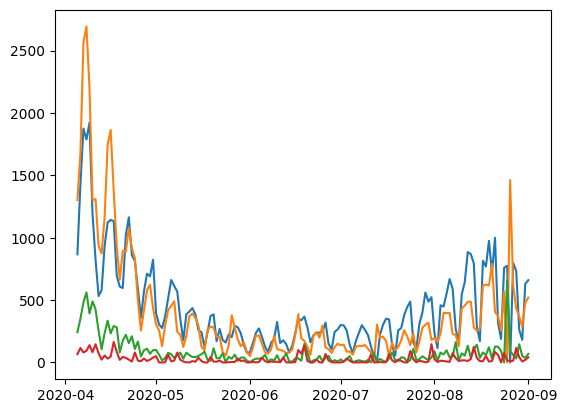

In [7]:
df = pd.read_csv(here() / "data/processed/RKI_4day_rt.csv")
i_start = 0
np1 = 150
data_selected = df.iloc[i_start : i_start + np1, 1:]
dates = pd.to_datetime(df.iloc[i_start : i_start + np1, 0])
y = jnp.asarray(data_selected.to_numpy())

plt.plot(dates, y)

plt.show()

In [8]:
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
from jax import random as jrn
from ssm4epi.models.util import visualize_pgssm

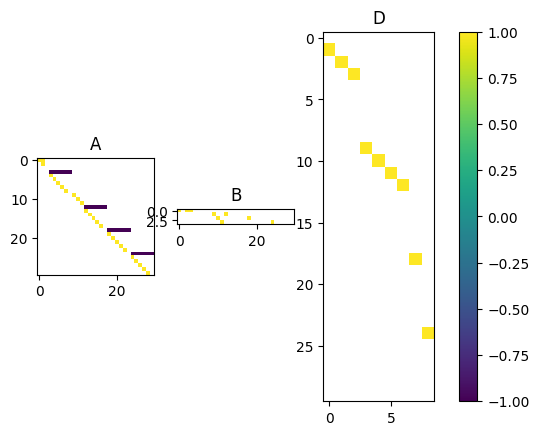

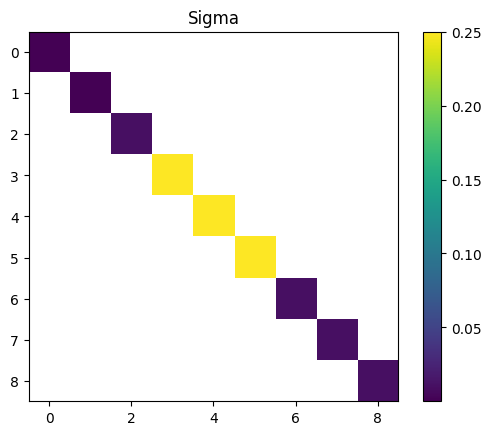

In [9]:
theta_manual = jnp.log(
    # s2_log_rho, s2_W, s2_q, s2_D
    jnp.array([0.001**2, 0.1**2, 0.5**2, 0.01**2, 0.1**2])
)

# allow variance to be larger as mean
aux = (np1, 4)
pgssm = _model(theta_manual, aux)

visualize_pgssm(pgssm)

## Monkey patching

In [10]:
# | export
# LA monkey patch
from isssm.kalman import kalman, smoothed_signals
from isssm.typing import GLSSM, GLSSMProposal, ConvergenceInformation
from isssm.laplace_approximation import default_link, vvmap, vdiag
from jax.scipy.optimize import minimize
from functools import partial
from isssm.util import converged
from jax import jacfwd, hessian, jacrev
from jax.lax import while_loop
import isssm.laplace_approximation


def _initial_guess(xi_t, y_t, dist, link=default_link):
    return jnp.array([jnp.log(y_t.sum() + 1), *jnp.zeros(3)])


isssm.laplace_approximation._initial_guess = _initial_guess
from ssm4epi.patch import full_deps

In [11]:
from isssm.laplace_approximation import laplace_approximation
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

key = jrn.PRNGKey(123423423)

In [12]:
from isssm.estimation import mle_pgssm, initial_theta

In [13]:
initial_result = initial_theta(y, _model, theta_manual, aux, 20)
theta0 = initial_result.x
initial_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.692800563209859
        x: [-8.423e+00 -7.476e+00 -4.235e+00 -3.989e+00 -4.155e-01]
      nit: 54
      jac: [ 2.887e-08  9.457e-08 -5.196e-07 -2.962e-07  3.264e-07]
 hess_inv: [[ 2.131e+02  9.607e+00 ... -2.118e+01  1.953e-01]
            [ 9.607e+00  1.806e+02 ... -1.266e+01  5.053e-02]
            ...
            [-2.118e+01 -1.266e+01 ...  1.930e+01  1.878e-01]
            [ 1.953e-01  5.053e-02 ...  1.878e-01  8.457e+00]]
     nfev: 660
     njev: 60

In [14]:
# key, subkey = jrn.split(key)
# mle_result = mle_pgssm(y, _model, theta0, aux, 20, 1000, subkey)
# theta_hat = mle_result.x
# mle_result

theta_hat = theta0

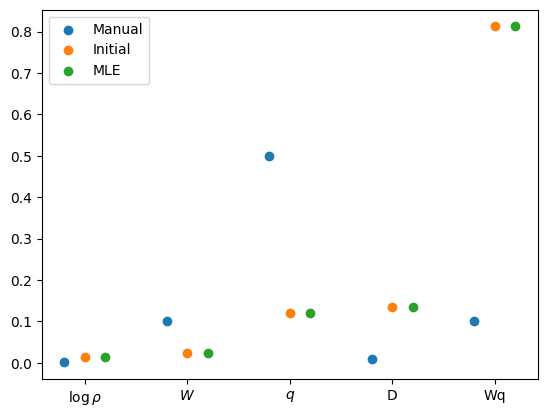

In [15]:
s_manual = jnp.exp(theta_manual / 2)
s_0 = jnp.exp(theta0 / 2)

k = theta_manual.size
plt.scatter(jnp.arange(k) - 0.2, s_manual, label="Manual")
plt.scatter(jnp.arange(k), s_0, label="Initial")
s_mle = jnp.exp(theta_hat / 2)
plt.scatter(jnp.arange(k) + 0.2, s_mle, label="MLE")
plt.xticks(jnp.arange(k), ["$\\log \\rho$", "$W$", "$q$", "D", "Wq"])
plt.legend()
plt.show()

In [16]:
fitted_model = _model(theta0, aux)

proposal_la, _ = laplace_approximation(y, fitted_model, 100)
key, subkey = jrn.split(key)
proposal_meis, _ = MEIS(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples_meis, log_weights_meis = pgssm_importance_sampling(
    y, fitted_model, proposal_meis.z, proposal_meis.Omega, 10000, subkey
)
key, subkey = jrn.split(key)
samples_la, log_weights_la = pgssm_importance_sampling(
    y, fitted_model, proposal_la.z, proposal_la.Omega, 10000, subkey
)
ess_pct(log_weights_la), ess_pct(log_weights_meis)

(Array(2.48342472, dtype=float64), Array(26.44461784, dtype=float64))

In [17]:
from isssm.importance_sampling import normalize_weights, mc_integration
from isssm.typing import GLSSM
from isssm.kalman import kalman, smoother, state_mode
from isssm.laplace_approximation import posterior_mode
from isssm.util import mm_time

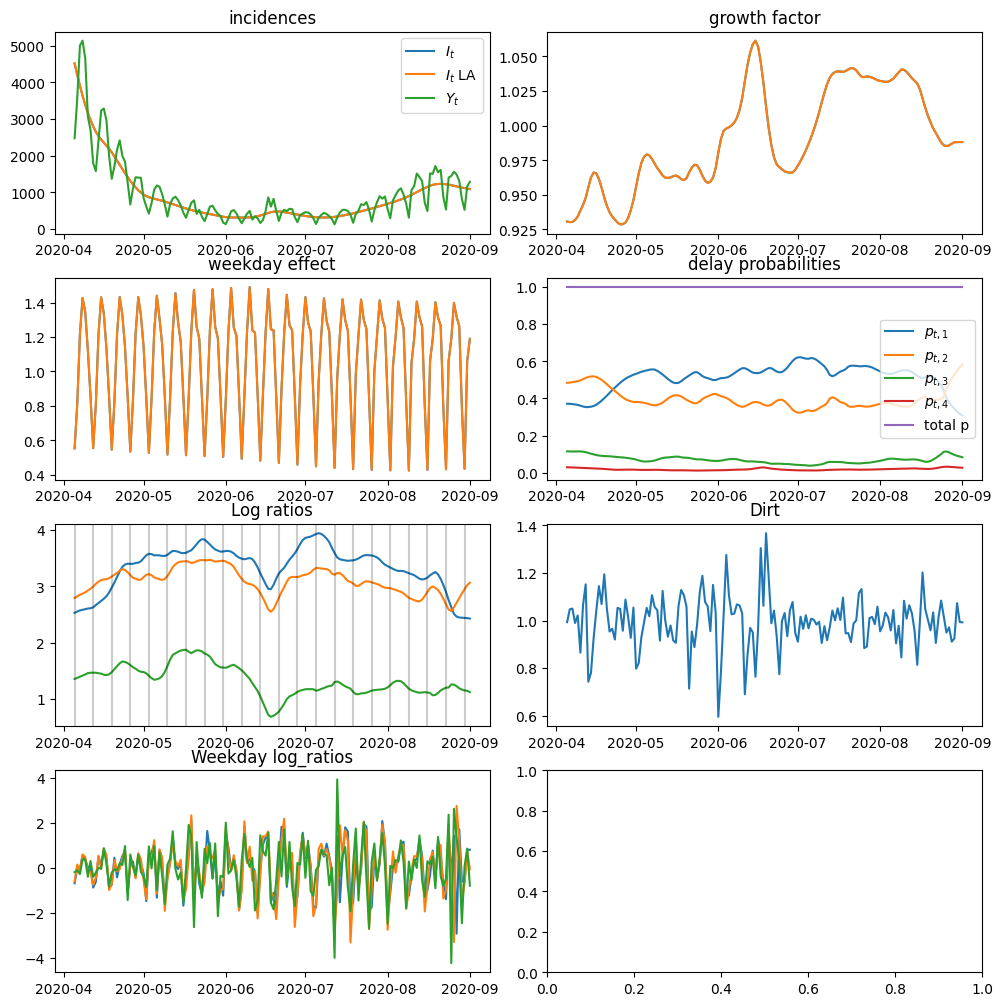

In [18]:
signal_la = posterior_mode(proposal_la)

state_modes_meis = vmap(state_mode, (None, 0))(fitted_model, samples_meis)
x_smooth = mc_integration(state_modes_meis, log_weights_meis)

x_smooth_la = state_mode(fitted_model, signal_la)

# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth_LA = jnp.exp(x_smooth_la[:, 0])

rho_smooth = jnp.exp(x_smooth[:, 1])
rho_smooth_LA = jnp.exp(x_smooth_la[:, 1])

D_smooth = jnp.exp(x_smooth[:, 2])
D_smooth_LA = jnp.exp(x_smooth_la[:, 2])

W_smooth = jnp.exp(x_smooth[:, 3])
W_smooth_LA = jnp.exp(x_smooth_la[:, 3])

log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(4, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
axs[0].plot(dates, I_smooth_LA, label="$I_t$ LA")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")
axs[1].plot(dates, rho_smooth_LA, label="$\\log \\rho_t$ LA")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")
axs[2].plot(dates, W_smooth_LA, label="$W_t$ LA")

axs[3].set_title("delay probabilities")


axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)

axs[6].set_title("Weekday log_ratios")
axs[6].plot(dates, x_smooth[:, jnp.array([13, 19, 25])])
plt.show()

## Christmas period model

In [19]:
dates.iloc[110]

Timestamp('2020-07-24 00:00:00')

In [21]:
christmas_inds = jnp.arange(75, 110)
y_nans = y.astype(jnp.float64).at[christmas_inds].set(jnp.nan)
christmas_inds = jnp.isnan(y_nans)

_, y_miss = account_for_nans(_model(theta0, aux), y_nans, christmas_inds)
_model_miss = lambda theta, aux: account_for_nans(
    _model(theta, aux), y_nans, christmas_inds
)[0]
theta0_miss = initial_theta(y_miss, _model_miss, theta_manual, aux, 100)
model_miss, y_miss = account_for_nans(
    _model(theta0_miss.x, aux), y_nans, christmas_inds
)
proposal_la_miss, _ = laplace_approximation(y_miss, model_miss, 100)
key, subkey = jrn.split(key)
proposal_meis_miss, _ = MEIS(
    y_miss, model_miss, proposal_la_miss.z, proposal_la_miss.Omega, 10, 4000, subkey
)

key, subkey = jrn.split(key)
missing_samples, missing_log_weights = pgssm_importance_sampling(
    y_miss,
    model_miss,
    proposal_meis_miss.z,
    proposal_meis.Omega,
    1000,
    subkey,
)
ess_pct(missing_log_weights)

Array(9.79010966, dtype=float64)

In [ ]:
ess_pct(missing_log_weights)

In [ ]:
x_smooth = (
    # vmap(smooth_x)(samples_la) * normalize_weights(log_weights_la)[:, None, None]
    vmap(state_mode, (None, 0))(model_miss, missing_samples)
    * normalize_weights(missing_log_weights)[:, None, None]
).sum(axis=0)


# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

I_smooth = jnp.exp(x_smooth[:, 0])
I_smooth_LA = jnp.exp(x_smooth_la[:, 0])

rho_smooth = jnp.exp(x_smooth[:, 1])
rho_smooth_LA = jnp.exp(x_smooth_la[:, 1])

D_smooth = jnp.exp(x_smooth[:, 2])
D_smooth_LA = jnp.exp(x_smooth_la[:, 2])

W_smooth = jnp.exp(x_smooth[:, 3])
W_smooth_LA = jnp.exp(x_smooth_la[:, 3])

log_ratios = x_smooth[:, 9:12]
log_probs = to_log_probs(log_ratios)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, I_smooth, label="$I_t$")
axs[0].plot(dates, I_smooth_LA, label="$I_t$ LA")
axs[0].plot(dates, y.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, rho_smooth, label="$\\log \\rho_t$")
axs[1].plot(dates, rho_smooth_LA, label="$\\log \\rho_t$ LA")

axs[2].set_title("weekday effect")
axs[2].plot(dates, W_smooth, label="$W_t$")
axs[2].plot(dates, W_smooth_LA, label="$W_t$ LA")

axs[3].set_title("delay probabilities")


axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()

axs[4].set_title("Log ratios")
axs[4].plot(dates, log_ratios[:, 0], label="$q_{t, 1}$")
axs[4].plot(dates, log_ratios[:, 1], label="$q_{t, 2}$")
axs[4].plot(dates, log_ratios[:, 2], label="$q_{t, 3}$")
for d in dates[::7]:
    axs[4].axvline(d, color="black", alpha=0.2)

axs[5].set_title("Dirt")
axs[5].plot(dates, D_smooth)
plt.show()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()